In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (e.g. sklearn and seaborn)


# Reading train data
df_credit_reports = pd.read_csv('./dataset/credit_reports.csv')
df_users = pd.read_csv('./dataset/users.csv')

# 1- First glance at data

## Missing data

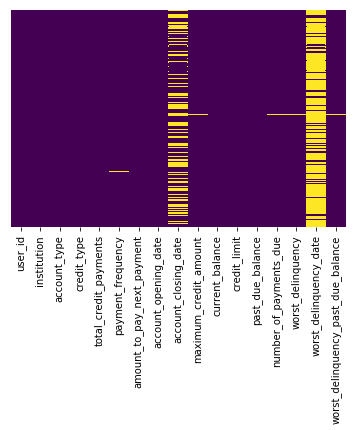

In [118]:
# Only dates are significantly missing in dates

sns.heatmap(pd.concat(objs=[df_credit_reports], axis=0).reset_index(drop=True).isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [119]:
# No missin data in users.csv
assert df_users.isnull().sum().sum() == 0

## Data merge

In [120]:
df_users.rename(index=str,columns={'id':'user_id'}, inplace=True)

In [121]:
df=pd.merge(df_users, df_credit_reports, on=['user_id'])

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16309 entries, 0 to 16308
Data columns (total 20 columns):
user_id                               16309 non-null int64
monthly_income                        16309 non-null int64
monthly_outcome                       16309 non-null int64
class                                 16309 non-null int64
institution                           16309 non-null object
account_type                          16309 non-null object
credit_type                           16309 non-null object
total_credit_payments                 16268 non-null float64
payment_frequency                     16308 non-null object
amount_to_pay_next_payment            16304 non-null float64
account_opening_date                  16309 non-null object
account_closing_date                  9068 non-null object
maximum_credit_amount                 16307 non-null float64
current_balance                       16304 non-null float64
credit_limit                          16296 non-null

## Correlations

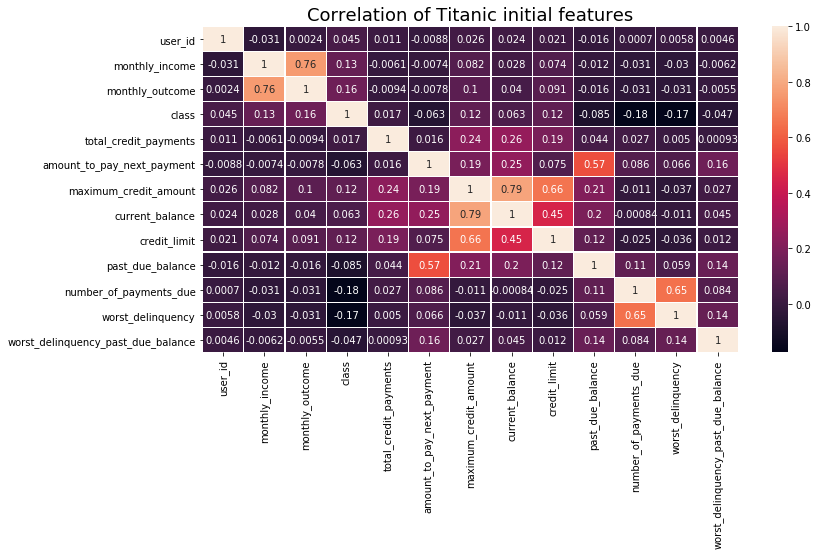

In [123]:
# Set-up figure
plt.figure(figsize=(12, 6))
# Title
plt.title('Correlation of Titanic initial features', fontsize=18)
# Correlation matrix
sns.heatmap(df.corr(), annot=True, linewidths=0.2)

# Remark: Non of the variables has correlation > 0.2 with class

# 2. Anomaly (Filter users without esencial data) 

### Direct estimage loan_amount

If loan IS delinquency:
loan_amount = total_credit_payments * past_due_balance / number_of_payments_due 

If loan is NOT delinquency:
loan_amount = total_credit_payments * amount_to_pay_next_payment

### Direct loan time lenght estimate:

Time estimate = total_credit_payments * payment_frequency

### Current balance needed to pay off the loan 

current_balance

### Amount to be paid on the next loan payment

amount_to_pay_next_payment

### Other insituteion estimate of how much we can lent to a client:

credit_limit - loan_amount

### Worst behaviour of a client with delinquencies 

worst_delinquency_past_due_balance

In [124]:
# In view of this information we really need this variables and we should not even consider clients
# on the basis of a previous loand without these data

esencial_data_list=[
              'number_of_payments_due',
              'current_balance',
              'past_due_balance',
              'worst_delinquency_past_due_balance',
              'amount_to_pay_next_payment',
              'total_credit_payments',
              'payment_frequency',
              'credit_limit']

In [125]:

anomalous_clients= df[ df[esencial_data_list[0]].isnull() | 
                       df[esencial_data_list[1]].isnull() | 
                       df[esencial_data_list[2]].isnull() | 
                       df[esencial_data_list[3]].isnull() |
                       df[esencial_data_list[4]].isnull() | 
                       df[esencial_data_list[5]].isnull() |
                       df[esencial_data_list[6]].isnull()|
                       df[esencial_data_list[7]].isnull()]
anomalous_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 1948 to 13208
Data columns (total 20 columns):
user_id                               52 non-null int64
monthly_income                        52 non-null int64
monthly_outcome                       52 non-null int64
class                                 52 non-null int64
institution                           52 non-null object
account_type                          52 non-null object
credit_type                           52 non-null object
total_credit_payments                 11 non-null float64
payment_frequency                     51 non-null object
amount_to_pay_next_payment            47 non-null float64
account_opening_date                  52 non-null object
account_closing_date                  5 non-null object
maximum_credit_amount                 50 non-null float64
current_balance                       47 non-null float64
credit_limit                          39 non-null float64
past_due_balance                    

In [126]:
# Observed that these all have some trace of delinquency/debt. 
anomalous_clients.describe()

,user_id,monthly_income,monthly_outcome,class,total_credit_payments,amount_to_pay_next_payment,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_past_due_balance
count,52.000000,5.200000e+01,52.000000,52.000000,11.000000,47.000000,50.000000,47.000000,39.000000,47.000000,40.000000,3.000000,40.00000
mean,523.076923,3.049638e+05,217096.961538,0.576923,62.545455,2251.765957,24860.600000,15387.021277,19381.333333,2650.446809,0.100000,1.333333,55.00000
std,163.923206,5.360667e+05,377831.444885,0.498867,50.349506,6808.734452,52275.065486,46029.834049,30040.207486,8531.076722,0.378932,1.154701,255.40315
min,96.000000,8.340000e+02,422.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,402.000000,3.256000e+03,7581.000000,0.000000,11.000000,0.000000,3295.500000,0.000000,1350.000000,0.000000,0.000000,1.000000,0.00000
50%,558.000000,3.468400e+04,9528.000000,1.000000,60.000000,0.000000,11628.500000,700.000000,11900.000000,0.000000,0.000000,2.000000,0.00000
75%,558.000000,5.692400e+04,53883.000000,1.000000,111.500000,1101.000000,16004.750000,9539.500000,20000.000000,0.000000,0.000000,2.000000,0.00000
max,792.000000,1.328843e+06,930751.000000,1.000000,119.000000,43372.000000,338800.000000,289213.000000,130393.000000,43372.000000,2.000000,2.000000,1450.00000


In [127]:
# The following anomaly dection fuction cleans separates such 
# clients.
df.dropna(subset=esencial_data_list,inplace=True)

## IMPORTANT!!! Any data we apply the analysis on should undertake the filters presented here. Otherwise our target probability distributions will be different, i.e. the following analysis does not apply!!!

# 3. Inspecting that entries that have esencial data

## worst_delinquency

In [128]:
df[df['worst_delinquency'].isnull()]

,user_id,monthly_income,monthly_outcome,class,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance
7294,402,1328843,930751,1,BANCO,Pagos Fijos,Préstamo Personal,48.0,Mensual,0.0,5/1/16,NaN,259000.0,0.0,259000.0,0.0,0.0,NaN,NaN,0.0
7296,402,1328843,930751,1,BANCO,Pagos Fijos,Préstamo Personal,24.0,Mensual,0.0,11/1/14,NaN,153480.0,0.0,153480.0,0.0,0.0,NaN,NaN,0.0
9712,558,34684,9528,1,BANCO,Pagos Fijos,Préstamo de Nomina,72.0,Quincenal,0.0,5/1/07,NaN,24000.0,0.0,6900.0,0.0,10.0,NaN,NaN,0.0
13200,792,56924,53883,0,BANCO,Pagos Fijos,Préstamo Personal,36.0,Mensual,3324.0,5/31/16,NaN,60000.0,50882.0,60000.0,0.0,0.0,NaN,NaN,0.0
13209,792,56924,53883,0,MICROFINANCIERA,Pagos Fijos,Préstamo Personal,52.0,Semanal,3820.0,8/4/16,NaN,42022.0,42022.0,0.0,0.0,2.0,NaN,NaN,0.0


In [129]:
#Observe that ofter missing data correspond to accounts without deliquency.
#The following funciton fills such missing data with 0's

def fill_worst_delinquency_nan(columns):
    worst_delinquency = columns[0]
    worst_delinquency_past_due_balance = columns[1]
    
    if (worst_delinquency_past_due_balance == 0.0) & pd.isnull(worst_delinquency) :
        return 0.
    else:
        return worst_delinquency

In [130]:
df['worst_delinquency']=df[['worst_delinquency','worst_delinquency_past_due_balance']].apply(fill_worst_delinquency_nan,axis=1)
assert df['worst_delinquency'].isnull().sum()==0

##  account_opening_date

In [131]:
assert df['account_opening_date'].isnull().sum()==0

df['account_opening_date'].map(lambda i: int(i[-2:])).unique()

array([14, 15, 16, 17, 11,  4,  9, 12, 13,  6,  8, 98, 10,  3, 18,  0,  5,
        7,  2,  1, 93, 50, 92, 79, 84, 99, 97, 89, 94, 91, 95, 88, 96, 83,
       78, 81, 87])

In [132]:
#df['account_opening_year']=df['account_opening_date'].map(lambda i: int(i[-2:])).map(lambda i: i-100 if i>=19 else i)

## worst_delinquency_date

In [133]:
# Lots of missing data. First, fill 'No' for 
# accounts without delinquencies, and 'Missing' when 
# information does not make any sense.
df[df['worst_delinquency_date'].isnull()]

,user_id,monthly_income,monthly_outcome,class,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance
0,0,255359,151439,1,MERCANCIA PARA HOGAR Y OFICINA,Pagos Fijos,Línea de Crédito,78.0,Semanal,0.0,11/10/14,12/5/15,9826.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
4,0,255359,151439,1,KONFIO,Pagos Fijos,Préstamo Personal,12.0,Quincenal,0.0,12/27/16,6/27/17,150000.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
5,0,255359,151439,1,KONFIO,Pagos Fijos,Préstamo Personal,26.0,Quincenal,10825.0,6/28/17,NaN,225000.0,159142.0,0.0,0.0,0.0,0.0,NaN,0.0
7,0,255359,151439,1,MERCANCIA PARA HOGAR Y OFICINA,Sin Límite Preestablecido,Crédito Personal al Consumo,0.0,Semanal,0.0,11/10/14,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0
8,0,255359,151439,1,AUTOMOTRIZ,Pagos Fijos,Compra de Automóvil,72.0,Mensual,5874.0,8/22/17,NaN,513069.0,475245.0,513069.0,0.0,0.0,0.0,NaN,0.0
9,0,255359,151439,1,AUTOMOTRIZ,Pagos Fijos,Compra de Automóvil,24.0,Mensual,10557.0,1/31/17,NaN,247705.0,124316.0,247705.0,0.0,0.0,0.0,NaN,0.0
10,0,255359,151439,1,BANCO,Revolvente,Tarjeta de Crédito,0.0,Mensual,1642.0,4/24/17,NaN,46307.0,40050.0,43500.0,0.0,0.0,0.0,NaN,0.0
11,0,255359,151439,1,FINANCIERA,Pagos Fijos,Compra de Automóvil,24.0,Mensual,3069.0,11/8/17,NaN,57959.0,57959.0,0.0,0.0,0.0,0.0,NaN,0.0
12,0,255359,151439,1,BANCO,Revolvente,Tarjeta de Crédito,0.0,Mensual,304.0,10/24/16,NaN,10000.0,6784.0,10000.0,0.0,0.0,0.0,NaN,0.0
13,0,255359,151439,1,COMUNICACIONES,Sin Límite Preestablecido,Línea de Crédito,1.0,Mensual,0.0,9/2/16,NaN,3068.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0


In [134]:
def fill_nan_worst_delinquency_date(columns):
    worst_del_date = columns[0]
    worst_del_balance = columns[1]
    
    if worst_del_balance == 0.0:
        return 'No'

    if worst_del_date == '0000-00-00':
        return 'Missing'
    
#    elif (type(worst_del_date)==str) & (str(worst_del_date)[-3]=='/'):
#        return worst_del_date
    
    else:
        return worst_del_date


In [135]:
df['worst_delinquency_date']=(
    df[['worst_delinquency_date','worst_delinquency_past_due_balance']]).apply(fill_nan_worst_delinquency_date,axis=1)

assert df['worst_delinquency_date'].isnull().sum()==0


## account_closing_date

In [136]:
df['account_closing_date'].isnull().sum(), df['account_closing_date'].notnull().sum()

(7194, 9063)

In [137]:
#Roughly half of the labels are missing for this feature. 

# In principle, we can infer some of this missing data:
# comparing account of each user_id with the same 
# opening date, with a loan granted from the same 
# institution. The following code shows that 
# there are ar least 577 such clients agaisn 
# whic are not of this type 5644.

# Warning! Closer inspection to the data set, shows 
# there are ids that ask for a loan, 
# from the same instution on the same day, 
# but still close accounts on different days.
# For this reason, we shall fill missing data 
# with 'No' meaning not in dataset. 


nan_plus_dates=0
only_nan=0
df_cd=df[df['account_closing_date'].isnull()]
for i in set(df_cd['user_id']):
    df_temp1=df[(df['user_id']==i)]
    for j in set(df_temp1['account_opening_date']):
        df_temp2=df_temp1[df_temp1['account_opening_date']==j]    
        temp=list(df_temp2['account_closing_date'])
        if (len(temp)>1) & ('/' in str(temp)) & ('nan' in str(temp)) : 
            nan_plus_dates+=1
        if (len(temp)==1) & ('nan' in str(temp)) : 
            only_nan+=1
nan_plus_dates, only_nan


(577, 5640)

In [138]:
temp_aux=df[df['account_closing_date'].isnull()]['account_opening_date'].map(lambda i : int(i[-2:]) )

print('Opening years:',temp_aux.unique())

print('No. of accounts, without closing date, opened before 2008:', (temp_aux<8 | (temp_aux>19)  ).sum())

print('No. of accounts, without closing date, opened between 2008-2018:', ((8<=temp_aux) & (temp_aux <= 19) ).sum())


Opening years: [16 17 14  4  9 12 13 15  6 11 98  8 18  0  2 10  5  1  7 50 92  3 79 99
 97 89 94 91 93 95 96 83 78 81 87]
No. of accounts, without closing date, opened before 2008: 22
No. of accounts, without closing date, opened between 2008-2018: 6576


In [139]:
# Observe, above, that most missing account openings are recent. 
# This information should already be indirectly
# contained in the 'account_closing_date'. Hence, 
# we will only keep a binary feature (1) if 
# reported, and (0) o.w. 

In [140]:
def turn_binary_account_closing_date(columns):
    date = columns[0]
    
    if pd.isnull(date):
        return 0
    
    elif (type(date)==str) & (str(date)[-3] == '/'):
        return 1
    
    else:
        return date

In [141]:
df['_has_account_closing_date']=df[['account_closing_date']].apply(turn_binary_account_closing_date,axis=1)
df.drop(['account_closing_date'], axis = 1, inplace = True)

## Payment_frequency

In [142]:
# The frequency of payment feature are:
df['payment_frequency'].unique()

array(['Semanal', 'Quincenal', 'Mensual', 'Catorcenal',
       'Una sola exhibición', 'Bimestral',
       'Pago mínimo para cuentas revolventes', 'Anual', 'Trimestral',
       'Deducción del salario'], dtype=object)

How many entries have payment_frequency: 'Deducción del salario', 'Pago mínimo para cuentas revolventes' or 
'Una sola exhibición'. These data is useless to us in view of the insights in the "Anomaly" section above. So 
we should get rid of such entries. 

In [143]:
anomalous_frec_pay_list=['Pago mínimo para cuentas revolventes','Deducción del salario','Una sola exhibición']

for i in anomalous_frec_pay_list:
    df = df[ df['payment_frequency'] != i ]
    
df['payment_frequency'].unique()

array(['Semanal', 'Quincenal', 'Mensual', 'Catorcenal', 'Bimestral',
       'Anual', 'Trimestral'], dtype=object)

# By now we have only enties with useful information

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15283 entries, 0 to 16308
Data columns (total 20 columns):
user_id                               15283 non-null int64
monthly_income                        15283 non-null int64
monthly_outcome                       15283 non-null int64
class                                 15283 non-null int64
institution                           15283 non-null object
account_type                          15283 non-null object
credit_type                           15283 non-null object
total_credit_payments                 15283 non-null float64
payment_frequency                     15283 non-null object
amount_to_pay_next_payment            15283 non-null float64
account_opening_date                  15283 non-null object
maximum_credit_amount                 15283 non-null float64
current_balance                       15283 non-null float64
credit_limit                          15283 non-null float64
past_due_balance                      15283 non-nu

In [145]:
# There is not an imbalance between good and bad clients!

df['class'].sum(), df['class'].sum()/df['class'].count()

(8633, 0.5648760060197605)

# Data Exploration

## institution: Institution granting the loan

In [146]:
assert df['institution'].isnull().sum()==0

In [147]:
def feature_labels(feature):
    return df[feature].unique(), df[feature].nunique()
    
feature_labels('institution')

(array(['MERCANCIA PARA HOGAR Y OFICINA', 'KONFIO', 'TELEFONIA CELULAR',
        'AUTOMOTRIZ', 'BANCO', 'FINANCIERA', 'COMUNICACIONES',
        'TIENDA COMERCIAL', 'MICROFINANCIERA',
        'ADMINISTRADORAS DE CARTERA', 'SERVICIOS', 'HIPOTECAGOBIERNO',
        'CIA Q  OTORGA', 'COBRANZA', 'MERCANCIA PARA LA CONSTRUCCION',
        'BANCOS', 'SERVICIO DE TELEVISION DE PAGA', 'TIENDA DEPARTAMENTAL',
        'TELEFONIA LOCAL Y DE LARGA DISTANCIA', 'VENTA POR CATALOGO',
        'GOBIERNO', 'SOCIEDADES FINANCIERAS POPULARES',
        'SOCIEDAD FINANCIERA DE OBJETO MULTIPLE', 'FONDOS Y FIDEICOMISOS',
        'GUBERNAMENTALES', 'COOPERATIVA', 'COMERCIAL', 'SERVS. GRALES.',
        'CAJAS DE AHORRO', 'COMPANIA DE FINANCIAMIENTO AUTOMOTRIZ',
        'AUTOFINANCIAMIENTO', 'TIENDA DE ROPA', 'ARRENDADORA', 'SIC',
        'COMPANIA DE PRESTAMO PERSONAL', 'OTRAS FINANCIERA',
        'FONDOS Y FIDEIC', 'BIENES RAICES', 'SOFOL PRESTAMO PERSONAL',
        'FACTORAJE', 'COOPERATIVA DE AHORRO Y CREDITO',

In [148]:
df['institution'].describe()

count     15283
unique       54
top       BANCO
freq       4257
Name: institution, dtype: object

In [149]:
# Table of institution coun appearance. 
pd.value_counts(df.institution).to_frame()

,institution
BANCO,4257
COMUNICACIONES,1674
MERCANCIA PARA HOGAR Y OFICINA,1407
FINANCIERA,1055
TIENDA DEPARTAMENTAL,972
BANCOS,706
SOCIEDAD FINANCIERA DE OBJETO MULTIPLE,655
TIENDA COMERCIAL,570
MICROFINANCIERA,489
SERVICIOS,469


Further studies should address how to group institutions in the mean time
we group them together according to whether they appear or not often (< 800 times)

/Users/rene/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


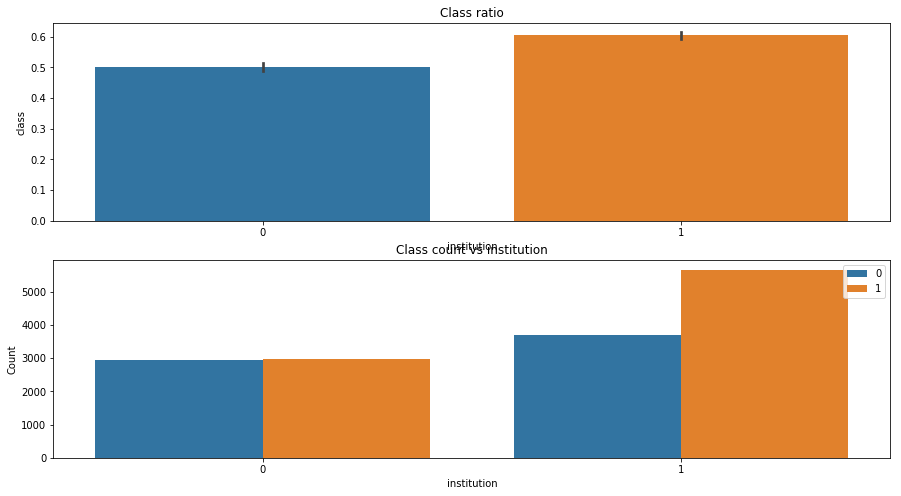

In [176]:

    
Class_and_count_vs('institution')

## account_type: Type of account for the institution.

In [177]:
assert df['account_type'].isnull().sum()==0
pd.value_counts(df.account_type).to_frame()

,account_type
Pagos Fijos,7247
Revolvente,4517
Sin Límite Preestablecido,2685
Crédito Prendario,526
Hipoteca,273
Quirografiario,28
Crédito de Habilitación de Avío,5
Crédito Refaccionario,2


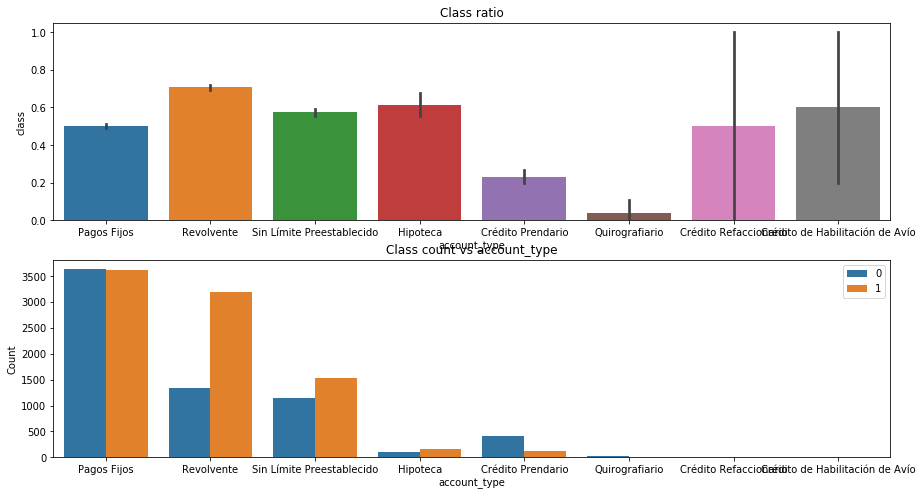

In [178]:
Class_and_count_vs('account_type')

## credit_type: Type of loan granted by the institution.

In [179]:
assert df['credit_type'].isnull().sum()==0
feature_labels('credit_type')

(array(['Línea de Crédito', 'Préstamo Personal ',
        'Crédito Personal al Consumo', 'Compra de Automóvil',
        'Tarjeta de Crédito', 'Otros (Múltiples Créditos)',
        'Bienes Raíces', 'Préstamo de Nomina', 'Crédito al Consumo',
        'Arrendamiento', 'Aparatos - Muebles', 'Arrendamiento Automotriz',
        'Crédito Fiscal', 'Préstamo Garantizado', 'Hipotecario O Vivienda',
        'Mejoras a la Casa', 'Grupo Solidario', 'Desconocido',
        'Física Actividad Empresarial', 'Préstamo Empresarial',
        'Préstamo Quirografiario', 'Tarjeta Departamental',
        'Préstamo para estudiante', 'Préstamo no garantizado', 'Factoraje',
        'Banca Comunal'], dtype=object), 26)

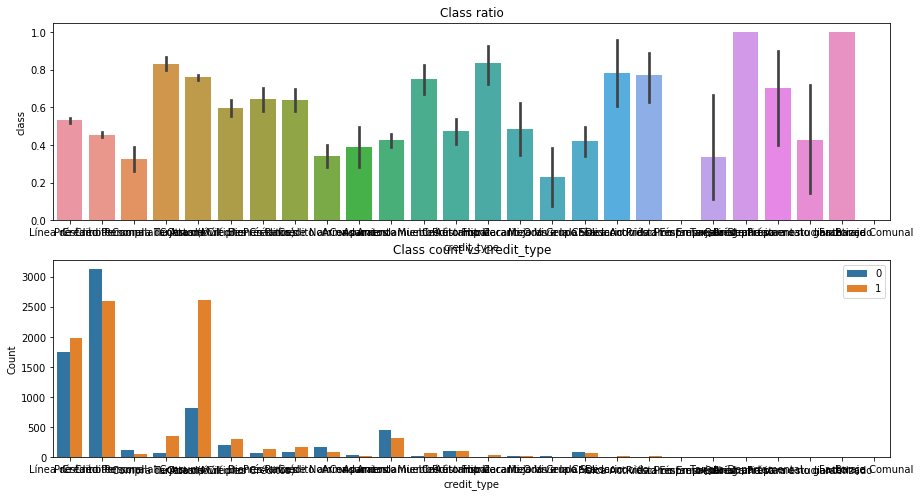

In [240]:
Class_and_count_vs('credit_type')

## total_credit_payments: Length of the credit (in amount of payments).
## payment_frequency: Frequency of the payments.

In [181]:
feature_labels('total_credit_payments')

(array([7.80e+01, 8.00e+01, 1.02e+02, 1.20e+02, 1.20e+01, 2.60e+01,
        1.00e+03, 0.00e+00, 7.20e+01, 2.40e+01, 1.00e+00, 6.00e+00,
        5.30e+01, 3.60e+02, 5.20e+01, 1.00e+02, 5.00e+01, 3.60e+01,
        7.00e+00, 4.80e+01, 6.00e+01, 4.00e+00, 6.50e+01, 1.80e+01,
        3.00e+01, 1.60e+01, 3.00e+00, 1.00e+01, 9.00e+01, 3.90e+01,
        5.90e+01, 1.50e+01, 4.30e+01, 2.00e+01, 1.10e+01, 7.00e+01,
        4.00e+01, 8.50e+01, 2.00e+00, 7.30e+01, 1.19e+02, 9.00e+02,
        1.40e+01, 1.30e+01, 1.28e+02, 3.10e+01, 9.00e+00, 2.10e+01,
        1.50e+02, 3.70e+01, 1.90e+01, 1.04e+02, 9.60e+01, 1.08e+02,
        9.10e+01, 2.08e+02, 9.70e+01, 5.10e+01, 9.90e+01, 2.20e+01,
        2.30e+01, 1.70e+01, 2.70e+01, 4.70e+01, 6.40e+01, 1.32e+02,
        3.12e+02, 8.00e+00, 4.10e+01, 1.56e+02, 4.20e+01, 2.50e+01,
        7.20e+02, 3.50e+01, 2.40e+02, 9.50e+01, 5.00e+00, 4.90e+01,
        7.50e+01, 4.50e+02, 3.01e+02, 1.43e+02, 7.10e+01, 1.80e+02,
        1.59e+02, 1.31e+02, 4.60e+01, 5.50e+01, 

In [161]:
df['total_credit_payments'].describe()

count    15283.000000
mean        23.741543
std         79.656235
min          0.000000
25%          0.000000
50%          1.000000
75%         16.000000
max       1800.000000
Name: total_credit_payments, dtype: float64

In [162]:
feature_labels('payment_frequency')

(array(['Semanal', 'Quincenal', 'Mensual', 'Catorcenal', 'Bimestral',
        'Anual', 'Trimestral'], dtype=object), 7)

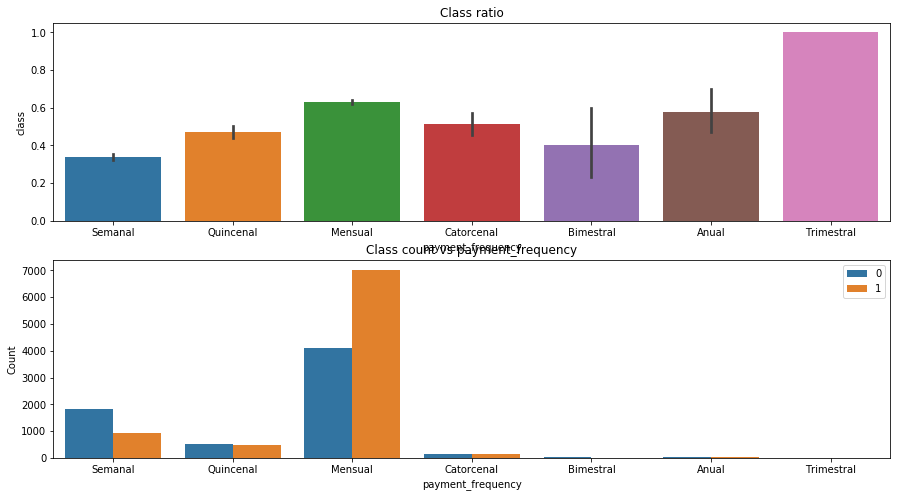

In [164]:
Class_and_count_vs('payment_frequency')

## amount_to_pay_next_payment

In [165]:
# only 5 missin data from teh same client
df[df['amount_to_pay_next_payment'].isnull()]
# Since this is a single client we better droped
# Improvement: search the distribution and replace

,user_id,monthly_income,monthly_outcome,class,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,...,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance,_has_account_closing_date,institution2


### Before plotting the distribution of this variable, we need to normalize to montly

In [166]:
df['amount_to_pay_next_payment'].describe()

count    1.528300e+04
mean     2.657982e+03
std      2.103293e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.170000e+02
max      1.263964e+06
Name: amount_to_pay_next_payment, dtype: float64

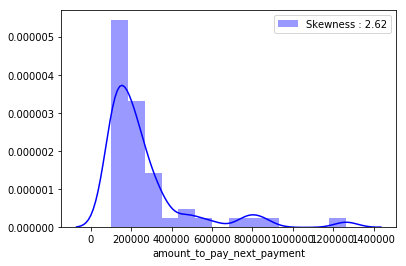

In [170]:
temp=df[df['amount_to_pay_next_payment'] >100000 ]['amount_to_pay_next_payment']
sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")

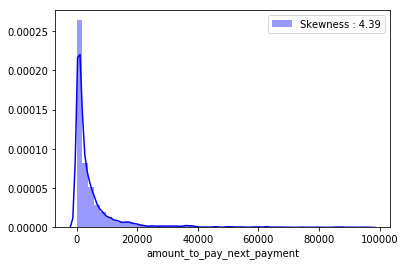

In [171]:
temp=df[(df['amount_to_pay_next_payment'] <=100000) & (df['amount_to_pay_next_payment'] >0) ]['amount_to_pay_next_payment']
sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")

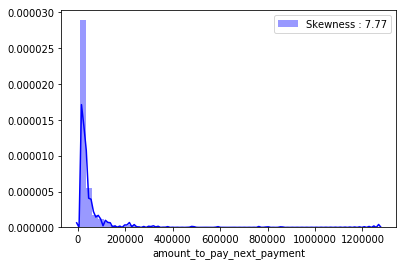

In [172]:
temp=df[ (df['amount_to_pay_next_payment'] >10000)]['amount_to_pay_next_payment']
sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")

The distribution is defintely not gaussian!

2319      798623.0
2659     1263964.0
3315      857867.0
8213      764858.0
10194     589569.0
Name: amount_to_pay_next_payment, dtype: float64

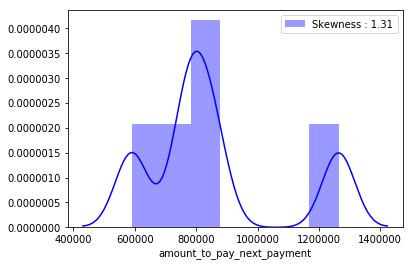

In [163]:
temp=df[df['amount_to_pay_next_payment'] >500000 ]['amount_to_pay_next_payment']
sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")
temp

In [174]:
payment_frequency_labels=df['payment_frequency'].unique()
payment_frequency_labels

array(['Semanal', 'Quincenal', 'Mensual', 'Catorcenal', 'Bimestral',
       'Anual', 'Trimestral'], dtype=object)

In [175]:
keys = payment_frequency_labels
values = [4 * 28 / 30, 2  , 1, 2 * 28 / 30, ]
dictionary = dict(zip(keys, values))
print(dictionary)
{'a': 1, 'b': 2, 'c': 3}

{'Semanal': 3.7333333333333334, 'Quincenal': 2, 'Mensual': 1, 'Catorcenal': 1.8666666666666667}


{'a': 1, 'b': 2, 'c': 3}

In [ ]:
df[df['payment_frequency']=='Una sola exhibición'].describe()

In [190]:
df[(df['payment_frequency']=='Una sola exhibición') & (df['number_of_payments_due'] >1)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 479 to 16018
Data columns (total 20 columns):
user_id                               49 non-null int64
monthly_income                        49 non-null int64
monthly_outcome                       49 non-null int64
class                                 49 non-null int64
institution                           49 non-null object
account_type                          49 non-null object
credit_type                           49 non-null object
total_credit_payments                 49 non-null float64
payment_frequency                     49 non-null object
amount_to_pay_next_payment            49 non-null float64
account_opening_date                  49 non-null object
account_closing_date                  5 non-null object
maximum_credit_amount                 49 non-null float64
current_balance                       49 non-null float64
credit_limit                          49 non-null float64
past_due_balance                     